In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.__version__

'2.2.0-dev20200508'

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import random

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth=True
# # config.gpu_options.per_process_gpu_memory_fraction = 0.9
# tf.compat.v1.Session(config=config)

In [3]:
### Model architecture

alpha = 0.5
inp = (128,128,3)
num_classes=13
    
inp = Input(shape=inp)
L1 = Conv2D(int(16*alpha),(3,3),padding='same')(inp)
L1 = BatchNormalization()(L1)
x = Activation('relu')(L1)

# conc = []

for filters in [32,64,128,256]:
    L = SeparableConv2D(int(filters*alpha),(3,3),padding='same')(x)
    L = BatchNormalization()(L)
    L = Activation('relu')(L)
    L = SeparableConv2D(int(filters*alpha),(3,3),padding='same')(L)
    L = BatchNormalization()(L)
    L = MaxPooling2D((2,2))(L)

    res = Conv2D(int(filters*alpha),(1,1),strides=2,padding='same')(x)
    x = Add()([L,res])
#     conc.append(x)


for filters in [256,128,64,32]:
    L = Conv2DTranspose(int(filters*alpha),(3,3),strides=2,padding='same')(x)
    L = BatchNormalization()(L)
    L = Activation('relu')(L)
    L = Conv2DTranspose(int(filters*alpha),(3,3),padding='same')(L)
    L = BatchNormalization()(L)
    L = Activation('relu')(L)
    
    res = UpSampling2D()(x)
    res = Conv2D(int(filters*alpha),(1,1),padding='same')(res)
    x = Add()([L,res])



out = Conv2D(num_classes,(1,1),activation='softmax')(x)


model = Model(inp,out)

model.summary()

print("Num layers: ", len(model.layers))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
from tqdm import tqdm 
P = '../Data/27201_34686_bundle_archive/dataA/dataA/'
image_files = os.listdir(os.path.join(P,'CameraRGB'))
mask_files = os.listdir(os.path.join(P,'CameraSeg'))

inp_shape = (128,128)

np.random.shuffle(image_files)
images = []
masks = []
for i in tqdm(range(len(image_files))):
    f = image_files[i]
    I = cv2.imread(os.path.join(P,'CameraRGB',f))
    I = cv2.cvtColor(I,cv2.COLOR_BGR2RGB)
    I = cv2.resize(I,inp_shape)
    images.append(I)
    
    mI = cv2.imread(os.path.join(P,'CameraSeg',f))
    mI = cv2.resize(mI,inp_shape)
    masks.append(mI)

100%|██████████| 1000/1000 [00:24<00:00, 40.74it/s]


In [5]:
X = np.array(images)
Y = np.array(masks)
indxs = np.arange(1000)
np.random.shuffle(indxs)
# Y = np.expand_dims(Y,axis=-1)
print(X.shape,Y.shape)

X_train = X[indxs[:800],:,:,:]
Y_train = Y[indxs[:800],:,:]
Y_train = np.expand_dims(np.max(Y_train,axis=-1),axis=-1)

X_test = X[indxs[800:900],:,:,:]
Y_test = Y[indxs[800:900],:,:]
Y_test = np.expand_dims(np.max(Y_test,axis=-1),axis=-1)

X_val = X[indxs[900:],:,:,:]
Y_val = Y[indxs[900:],:,:]
Y_val = np.expand_dims(np.max(Y_val,axis=-1),axis=-1)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape)

(1000, 128, 128, 3) (1000, 128, 128, 3)
(800, 128, 128, 3) (800, 128, 128, 1)
(100, 128, 128, 3) (100, 128, 128, 1)
(100, 128, 128, 3) (100, 128, 128, 1)


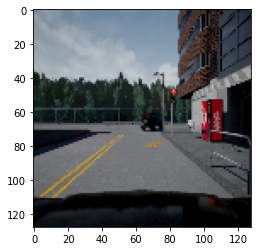

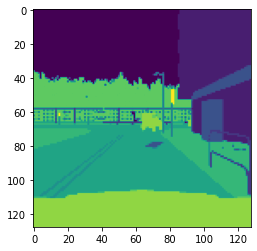

In [6]:
ind = random.randint(0,800)

plt.figure()
plt.imshow(X_train[ind,:,:,:])

plt.figure()
plt.imshow(Y_train[ind,:,:].reshape(128,128))

In [7]:
print(np.unique(Y_train[np.random.randint(len(Y_train))]))
# print(np.unique(np.max(Y_val,axis=-1)))
# print(np.max(Y_val,axis=-1).shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [26]:
### Image data generator 


# Train generator
seed = 666

train_img_datagen = ImageDataGenerator(
#     width_shift_range=0.05,
#     height_shift_range=0.05,
    horizontal_flip=True,
    rescale=1/255.,
#     vertical_flip=True,
    fill_mode='reflect')

train_mask_gen = ImageDataGenerator(
#     width_shift_range=0.05,
#     height_shift_range=0.05,
    horizontal_flip=True,
#     rescale=1/255.,
#     vertical_flip=True,
    fill_mode='reflect')

train_img_datagen.fit(X_train, augment=True, seed=seed)
train_mask_gen.fit(Y_train, augment=True, seed=seed)

x=train_img_datagen.flow(X_train,batch_size=16,shuffle=True, seed=seed)
y=train_mask_gen.flow(Y_train,batch_size=16,shuffle=True, seed=seed)

# Validation generator
# seed1 = 660

val_img_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.,
    fill_mode='reflect')

val_mask_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
#     rescale=1/255.,
    fill_mode='reflect')

val_img_datagen.fit(X_test, augment=True, seed=seed)
val_mask_gen.fit(Y_test, augment=True, seed=seed)

x_val=val_img_datagen.flow(X_test,batch_size=8,shuffle=True, seed=seed)
y_val=val_mask_gen.flow(Y_test,batch_size=8,shuffle=True, seed=seed)


Sample Train Image


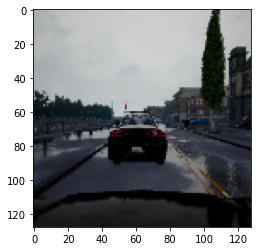

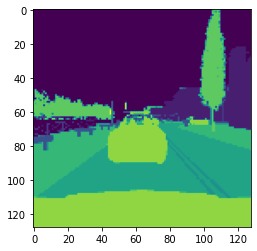

Sample Validation Image


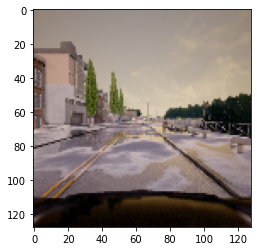

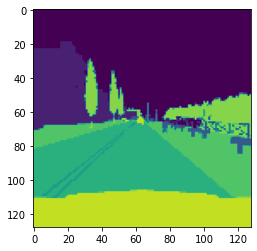

In [27]:
idx = np.random.randint(8)
rescale=1.
rescaleMask=255.

print("Sample Train Image")
k = next(x)
plt.imshow(k[idx]/rescale)
plt.show()

k = next(y)
plt.imshow(np.squeeze(k[idx])/rescaleMask)
plt.show()

# print(np.unique(k[idx]))


print("Sample Validation Image")
k = next(x_val)
plt.imshow(k[idx]/rescale)
plt.show()

k = next(y_val)
plt.imshow(np.squeeze(k[idx])/rescaleMask)
plt.show()

In [8]:
ckpt_dir = '/home/sivananda/CARLA_Seg/CKPTs/'
os.makedirs(ckpt_dir,exist_ok=True)
model.compile(keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')

In [9]:
checkpoint = ModelCheckpoint(os.path.join(ckpt_dir,'stage_1_best.h5'),monitor='val_loss',save_weights_only=False,save_best_only=True)
# model.load_weights(os.path.join(ckpt_dir,'stage_1_best.h5'))

In [11]:
history = model.fit(x=X_train,y=Y_train,batch_size=16,epochs=50,verbose=1,callbacks=[checkpoint],validation_data=(X_test,Y_test),
    shuffle=True,initial_epoch=0,steps_per_epoch=(800 // 16)+1,validation_steps=(100//8)+1,
    validation_batch_size=8,workers=1,use_multiprocessing=False)

Epoch 1/50
51/51 [==============================] - 36s 703ms/step - loss: 1.1460 - val_loss: 2.3625
Epoch 2/50
51/51 [==============================] - 34s 666ms/step - loss: 0.6474 - val_loss: 1.9819
Epoch 3/50
51/51 [==============================] - 34s 664ms/step - loss: 0.5591 - val_loss: 1.9902
Epoch 4/50
51/51 [==============================] - 34s 664ms/step - loss: 0.5146 - val_loss: 2.0281
Epoch 5/50
51/51 [==============================] - 34s 664ms/step - loss: 0.4647 - val_loss: 2.0488
Epoch 6/50
51/51 [==============================] - 34s 663ms/step - loss: 0.4472 - val_loss: 1.9855
Epoch 7/50
51/51 [==============================] - 35s 687ms/step - loss: 0.4275 - val_loss: 1.4789
Epoch 8/50
51/51 [==============================] - 34s 669ms/step - loss: 0.4125 - val_loss: 1.0935
Epoch 9/50
51/51 [==============================] - 34s 668ms/step - loss: 0.3897 - val_loss: 0.6058
Epoch 10/50
51/51 [==============================] - 34s 671ms/step - loss: 0.3766 - val_lo

In [26]:
checkpoint = ModelCheckpoint(os.path.join(ckpt_dir,'stage_3_best.h5'),monitor='val_loss',save_weights_only=False,save_best_only=True)
model.load_weights(os.path.join(ckpt_dir,'stage_2_best.h5'))
model.compile(keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy')

In [27]:
history = model.fit(x=X_train,y=Y_train,batch_size=64,epochs=50,verbose=1,callbacks=[checkpoint],validation_data=(X_test,Y_test),
    shuffle=True,initial_epoch=0,steps_per_epoch=(800 // 64)+1,validation_steps=(100//32)+1,
    validation_batch_size=32,workers=1,use_multiprocessing=False)

Epoch 1/50
13/13 [==============================] - 34s 3s/step - loss: 0.2176 - val_loss: 0.3306
Epoch 2/50
13/13 [==============================] - 33s 3s/step - loss: 0.2173 - val_loss: 0.3307
Epoch 3/50
13/13 [==============================] - 33s 3s/step - loss: 0.2173 - val_loss: 0.3308
Epoch 4/50
13/13 [==============================] - 33s 3s/step - loss: 0.2172 - val_loss: 0.3310
Epoch 5/50
13/13 [==============================] - 33s 3s/step - loss: 0.2169 - val_loss: 0.3310
Epoch 6/50
13/13 [==============================] - 33s 3s/step - loss: 0.2168 - val_loss: 0.3311
Epoch 7/50
13/13 [==============================] - 33s 3s/step - loss: 0.2168 - val_loss: 0.3310
Epoch 8/50
13/13 [==============================] - 33s 3s/step - loss: 0.2167 - val_loss: 0.3313
Epoch 9/50
13/13 [==============================] - 33s 3s/step - loss: 0.2163 - val_loss: 0.3314
Epoch 10/50
13/13 [==============================] - 33s 3s/step - loss: 0.2166 - val_loss: 0.3314
Epoch 11/50
13/13 [

In [30]:
train_gen = zip(x,y)
test_gen = zip(x_val,y_val)
train_len = 800
test_len = 100

In [ ]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=(train_len // 16)+1, 
                    epochs=50, 
                    initial_epoch=0,
                    validation_data=test_gen,
                    validation_steps=(test_len//8)+1,
                    callbacks=[checkpoint],
                    use_multiprocessing=False)
#                     use_multiprocessing=True, workers=2)

Epoch 1/50
51/51 [==============================] - 36s 701ms/step - loss: 0.5732 - val_loss: 2.7198
Epoch 2/50
51/51 [==============================] - 35s 693ms/step - loss: 0.5046 - val_loss: 2.6771
Epoch 3/50
51/51 [==============================] - 35s 690ms/step - loss: 0.4572 - val_loss: 2.7932
Epoch 4/50
 7/51 [===>..........................] - ETA: 29s - loss: 0.4133

dict_keys(['loss', 'val_loss'])


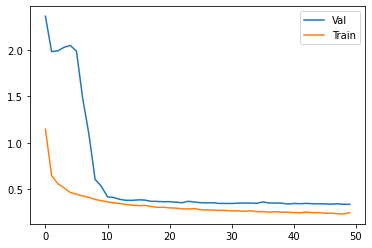

In [12]:
print(history.history.keys())
plt.plot(history.history['val_loss'],label="Val")
plt.plot(history.history['loss'],label="Train")
plt.legend()
plt.show()

In [28]:
model.load_weights(os.path.join(ckpt_dir,'stage_3_best.h5'))
model.save(os.path.join(ckpt_dir,'simple_RES_Unet_260820.h5'))

In [29]:
res = model.evaluate(X_val,Y_val)
res

4/4 [==============================] - 1s 204ms/step - loss: 0.3092


0.30921265482902527

In [15]:
color_map = {
    0:(0, 0, 0),
    1:( 70, 70, 70),
    2:(190, 153, 153),
    3:(250, 170, 160),
    4:(220, 20, 60),
    5:(153, 153, 153),
    6:(157, 234, 50),
    7:(128, 64, 128),
    8:(244, 35, 232),
    9:(107, 142, 35),
    10:( 0, 0, 142),
    11:(102, 102, 156),
    12:(220, 220, 0)
}

idx:  50


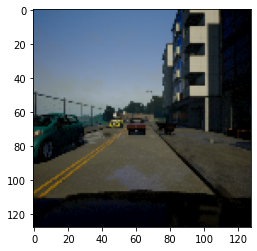

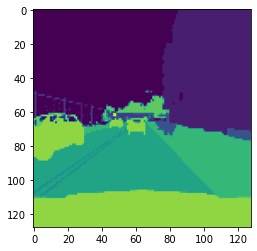

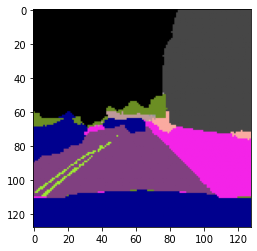

In [36]:
idx = np.random.randint(len(X_val))
print("idx: ",idx)
img = X_val[idx]

plt.imshow(img/255.)
plt.show()

plt.imshow(np.squeeze(Y_val[idx])/255.)
plt.show()

inp = np.reshape(img,(1,128,128,3))
p1 = model.predict(inp)
p = np.argmax(p1[0],axis=-1)
# print(p.shape)
# print(np.unique(p))
# print(p1[0,45,45,:],np.max(p1[0,45,45,:],axis=-1),np.argmax(p1[0,45,45,:],axis=-1))
mask_img = np.zeros((128,128,3))
for i in range(num_classes):
    mask_img[p==i] = color_map[i]
        
plt.imshow(mask_img/255.)
plt.show()

In [16]:
idx

62